# Measuring Word and Phrase Repetition Between Lines

In [ ]:
# setup
!pip install -q spacy
!python -m spacy download en_core_web_sm -q

import spacy
import pandas as pd

nlp = spacy.load("en_core_web_sm")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 103.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# function to keep pronouns out of stop words list
def is_pronoun(tok):
    """Return True if the token is a pronoun."""
    return tok.pos_ == "PRON" or tok.tag_.startswith("PRP")


def longest_common_phrase(tokens1, tokens2):
    """
    Longest common contiguous sequence between two token lists.
    Returns (max_len, phrase_tokens_list).
    """
    # empty case
    if not tokens1 or not tokens2:
        return 0, []

    m, n = len(tokens1), len(tokens2)
    dp = [[0] * (n + 1) for _ in range(m + 1)]
    max_len = 0
    end_i = 0

    for i in range(1, m + 1):
        ti = tokens1[i - 1]
        row_i = dp[i]
        row_im1 = dp[i - 1]
        for j in range(1, n + 1):
            if ti == tokens2[j - 1]:
                val = row_im1[j - 1] + 1
                row_i[j] = val
                if val > max_len:
                    max_len = val
                    end_i = i
            else:
                row_i[j] = 0

    if max_len == 0:
        return 0, []

    start_i = end_i - max_len
    return max_len, tokens1[start_i:end_i]


def analyze_duplex_word_and_phrase_matches(poem_text):
    """
    Analyzer for ONE entire poem string.

    Returns:
      pairs_df: one row per pair (adjacent + first_last) with:
          - pair_index
          - pair_type           ("adjacent" or "first_last")
          - matches             (comma-separated content-word lemmas)
          - num_matches
          - max_phrase_len      (longest repeated phrase, in words)
          - max_phrase_example  (one such phrase)
          - passes_echo

      summary: dict with:
          - n_lines
          - num_pairs_passing_echo   (adjacent pairs only)
          - first_last_passes_echo
    """
    if poem_text is None:
        poem_text = ""
    poem_text = str(poem_text)

    # split into non-empty lines
    lines = [ln.strip() for ln in poem_text.splitlines() if ln.strip()]
    n_lines = len(lines)

    if n_lines == 0:
        empty_pairs = pd.DataFrame(columns=[
            "pair_index", "pair_type", "matches", "num_matches",
            "max_phrase_len", "max_phrase_example", "passes_echo",
        ])
        summary = {
            "n_lines": 0,
            "num_pairs_passing_echo": 0,
            "first_last_passes_echo": False,
        }
        return empty_pairs, summary

    # process all lines for this poem in one spaCy batch
    docs = list(nlp.pipe(lines, batch_size=64))

    content_sets = []
    token_lists = []

    for doc in docs:
        content_words = set()
        surface_tokens = []

        for tok in doc:
            if tok.is_space or tok.is_punct:
                continue

            surface_tokens.append(tok.text.lower())  # phrase-level
            lemma = tok.lemma_.lower()               # word-level

            if is_pronoun(tok) or not tok.is_stop:
                content_words.add(lemma)

        content_sets.append(content_words)
        token_lists.append(surface_tokens)

    pair_rows = []
    pair_index = 0

    def add_pair(i, j, pair_type):
        nonlocal pair_index
        # word-level overlap
        matches_set = content_sets[i] & content_sets[j]
        matches_list = sorted(matches_set)
        num_matches = len(matches_list)

        # phrase-level overlap
        max_len, phrase_tokens = longest_common_phrase(
            token_lists[i],
            token_lists[j],
        )
        max_phrase_example = " ".join(phrase_tokens) if max_len > 0 else ""

        # echo rule: at least 1 content word OR phrase length >= 2
        passes_echo = (num_matches >= 1) or (max_len >= 2)

        pair_rows.append({
            "pair_index": pair_index,
            "pair_type": pair_type,
            "matches": ", ".join(matches_list) if matches_list else "",
            "num_matches": num_matches,
            "max_phrase_len": max_len,
            "max_phrase_example": max_phrase_example,
            "passes_echo": passes_echo,
        })

        pair_index += 1

    # adjacent pairs
    for i in range(n_lines - 1):
        add_pair(i, i + 1, "adjacent")

    # first–last pair
    if n_lines >= 2:
        add_pair(0, n_lines - 1, "first_last")
        first_last_passes_echo = bool(pair_rows[-1]["passes_echo"])
    else:
        first_last_passes_echo = False

    pairs_df = pd.DataFrame(pair_rows)

    # summary: only adjacent pairs counted for num_pairs_passing_echo
    if n_lines > 1 and not pairs_df.empty:
        num_pairs_passing_echo = int(
            pairs_df[pairs_df["pair_type"] == "adjacent"]["passes_echo"].sum()
        )
    else:
        num_pairs_passing_echo = 0

    summary = {
        "n_lines": n_lines,
        "num_pairs_passing_echo": num_pairs_passing_echo,
        "first_last_passes_echo": first_last_passes_echo,
    }

    return pairs_df, summary

## Original Brown Duplexes

In [ ]:
from google.colab import files
uploaded = files.upload()

input_filename = list(uploaded.keys())[0]
print("Using file:", input_filename)

import os
base = os.path.splitext(input_filename)[0]

Saving original_brown_duplexes (1).csv to original_brown_duplexes (1).csv
Using file: original_brown_duplexes (1).csv


In [ ]:
import pandas as pd

df = pd.read_csv(input_filename)
df = df.reset_index().rename(columns={"index": "poem_id"})

poem_rows = []
pair_tables = []

for _, row in df.iterrows():
    poem_id = row["poem_id"]
    pairs_df, summary = analyze_duplex_word_and_phrase_matches(row["poem_text"])

    poem_rows.append({
        "poem_id": poem_id,
        "author": row["author"],
        "poem_title": row["poem_title"],
        "form": row["form"],
        "n_lines": summary["n_lines"],
        "num_pairs_passing_echo": summary["num_pairs_passing_echo"],
        "first_last_passes_echo": summary["first_last_passes_echo"],
    })

    if not pairs_df.empty:
        tmp = pairs_df.copy()
        tmp["poem_id"] = poem_id
        tmp["author"] = row["author"]
        tmp["poem_title"] = row["poem_title"]
        tmp["form"] = row["form"]
        pair_tables.append(tmp)

poem_summary_filename = f"{base}_summary.csv"
pd.DataFrame(poem_rows).to_csv(poem_summary_filename, index=False)

pairs_filename = f"{base}_pairs.csv"
if pair_tables:
    pd.concat(pair_tables, ignore_index=True).to_csv(pairs_filename, index=False)
else:
    pd.DataFrame().to_csv(pairs_filename, index=False)

print("Created:", poem_summary_filename, "and", pairs_filename)

Created: original_brown_duplexes (1)_summary.csv and original_brown_duplexes (1)_pairs.csv


In [ ]:
files.download(poem_summary_filename)
files.download(pairs_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## ChatGPT 4 Duplexes

In [ ]:
from google.colab import files
uploaded = files.upload()

input_filename = list(uploaded.keys())[0]
print("Using file:", input_filename)

import os
base = os.path.splitext(input_filename)[0]

Saving GPT4_all_poems_clean.csv to GPT4_all_poems_clean.csv
Using file: GPT4_all_poems_clean.csv


In [ ]:
import pandas as pd

df = pd.read_csv(input_filename)
df = df.reset_index().rename(columns={"index": "poem_id"})

poem_rows = []
pair_tables = []

for _, row in df.iterrows():
    poem_id = row["poem_id"]
    pairs_df, summary = analyze_duplex_word_and_phrase_matches(row["poem_text"])

    poem_rows.append({
        "poem_id": poem_id,
        "subject": row["subject"],
        "with_brown_rules": row["with_brown_rules"],
        "prompt_type": row["prompt_type"],
        "n_lines": summary["n_lines"],
        "num_pairs_passing_echo": summary["num_pairs_passing_echo"],
        "first_last_passes_echo": summary["first_last_passes_echo"],
    })

    if not pairs_df.empty:
        tmp = pairs_df.copy()
        tmp["poem_id"] = poem_id
        tmp["subject"] = row["subject"]
        tmp["with_brown_rules"] = row["with_brown_rules"]
        tmp["prompt_type"] = row["prompt_type"]
        pair_tables.append(tmp)

poem_summary_filename = f"{base}_summary.csv"
pd.DataFrame(poem_rows).to_csv(poem_summary_filename, index=False)

pairs_filename = f"{base}_pairs.csv"
if pair_tables:
    pd.concat(pair_tables, ignore_index=True).to_csv(pairs_filename, index=False)
else:
    pd.DataFrame().to_csv(pairs_filename, index=False)

print("Created:", poem_summary_filename, "and", pairs_filename)

Created: GPT4_all_poems_clean_summary.csv and GPT4_all_poems_clean_pairs.csv


In [ ]:
files.download(poem_summary_filename)
files.download(pairs_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## ChatGPT 4o-mini Duplexes

In [ ]:
from google.colab import files
uploaded = files.upload()

input_filename = list(uploaded.keys())[0]
print("Using file:", input_filename)

import os
base = os.path.splitext(input_filename)[0]

Saving 4o_mini_all_poems_clean.csv to 4o_mini_all_poems_clean.csv
Using file: 4o_mini_all_poems_clean.csv


In [ ]:
import pandas as pd

df = pd.read_csv(input_filename)
df = df.reset_index().rename(columns={"index": "poem_id"})

poem_rows = []
pair_tables = []

for _, row in df.iterrows():
    poem_id = row["poem_id"]
    pairs_df, summary = analyze_duplex_word_and_phrase_matches(row["poem_text"])

    poem_rows.append({
        "poem_id": poem_id,
        "subject": row["subject"],
        "with_brown_rules": row["with_brown_rules"],
        "prompt_type": row["prompt_type"],
        "n_lines": summary["n_lines"],
        "num_pairs_passing_echo": summary["num_pairs_passing_echo"],
        "first_last_passes_echo": summary["first_last_passes_echo"],
    })

    if not pairs_df.empty:
        tmp = pairs_df.copy()
        tmp["poem_id"] = poem_id
        tmp["subject"] = row["subject"]
        tmp["with_brown_rules"] = row["with_brown_rules"]
        tmp["prompt_type"] = row["prompt_type"]
        pair_tables.append(tmp)

poem_summary_filename = f"{base}_summary.csv"
pd.DataFrame(poem_rows).to_csv(poem_summary_filename, index=False)

pairs_filename = f"{base}_pairs.csv"
if pair_tables:
    pd.concat(pair_tables, ignore_index=True).to_csv(pairs_filename, index=False)
else:
    pd.DataFrame().to_csv(pairs_filename, index=False)

print("Created:", poem_summary_filename, "and", pairs_filename)

Created: 4o_mini_all_poems_clean_summary.csv and 4o_mini_all_poems_clean_pairs.csv


In [ ]:
files.download(poem_summary_filename)
files.download(pairs_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## OMLo Duplexes

In [ ]:
from google.colab import files
uploaded = files.upload()

input_filename = list(uploaded.keys())[0]
print("Using file:", input_filename)

import os
base = os.path.splitext(input_filename)[0]

Saving olmo_all_poems_clean.csv to olmo_all_poems_clean.csv
Using file: olmo_all_poems_clean.csv


In [ ]:
import pandas as pd

df = pd.read_csv(input_filename)
df = df.reset_index().rename(columns={"index": "poem_id"})

poem_rows = []
pair_tables = []

for _, row in df.iterrows():
    poem_id = row["poem_id"]
    pairs_df, summary = analyze_duplex_word_and_phrase_matches(row["poem_text"])

    poem_rows.append({
        "poem_id": poem_id,
        "subject": row["subject"],
        "with_brown_rules": row["with_brown_rules"],
        "prompt_type": row["prompt_type"],
        "n_lines": summary["n_lines"],
        "num_pairs_passing_echo": summary["num_pairs_passing_echo"],
        "first_last_passes_echo": summary["first_last_passes_echo"],
    })

    if not pairs_df.empty:
        tmp = pairs_df.copy()
        tmp["poem_id"] = poem_id
        tmp["subject"] = row["subject"]
        tmp["with_brown_rules"] = row["with_brown_rules"]
        tmp["prompt_type"] = row["prompt_type"]
        pair_tables.append(tmp)

poem_summary_filename = f"{base}_summary.csv"
pd.DataFrame(poem_rows).to_csv(poem_summary_filename, index=False)

pairs_filename = f"{base}_pairs.csv"
if pair_tables:
    pd.concat(pair_tables, ignore_index=True).to_csv(pairs_filename, index=False)
else:
    pd.DataFrame().to_csv(pairs_filename, index=False)

print("Created:", poem_summary_filename, "and", pairs_filename)

Created: olmo_all_poems_clean_summary.csv and olmo_all_poems_clean_pairs.csv


In [ ]:
files.download(poem_summary_filename)
files.download(pairs_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Claude Duplexes

In [ ]:
from google.colab import files
uploaded = files.upload()

input_filename = list(uploaded.keys())[0]
print("Using file:", input_filename)

import os
base = os.path.splitext(input_filename)[0]

Saving claude_all_poems_clean.csv to claude_all_poems_clean (1).csv
Using file: claude_all_poems_clean (1).csv


In [ ]:
import pandas as pd

df = pd.read_csv(input_filename)
df = df.reset_index().rename(columns={"index": "poem_id"})

poem_rows = []
pair_tables = []

for _, row in df.iterrows():
    poem_id = row["poem_id"]
    pairs_df, summary = analyze_duplex_word_and_phrase_matches(row["poem_text"])

    poem_rows.append({
        "poem_id": poem_id,
        "subject": row["subject"],
        "with_brown_rules": row["with_brown_rules"],
        "prompt_type": row["prompt_type"],
        "n_lines": summary["n_lines"],
        "num_pairs_passing_echo": summary["num_pairs_passing_echo"],
        "first_last_passes_echo": summary["first_last_passes_echo"],
    })

    if not pairs_df.empty:
        tmp = pairs_df.copy()
        tmp["poem_id"] = poem_id
        tmp["subject"] = row["subject"]
        tmp["with_brown_rules"] = row["with_brown_rules"]
        tmp["prompt_type"] = row["prompt_type"]
        pair_tables.append(tmp)

poem_summary_filename = f"{base}_summary.csv"
pd.DataFrame(poem_rows).to_csv(poem_summary_filename, index=False)

pairs_filename = f"{base}_pairs.csv"
if pair_tables:
    pd.concat(pair_tables, ignore_index=True).to_csv(pairs_filename, index=False)
else:
    pd.DataFrame().to_csv(pairs_filename, index=False)

print("Created:", poem_summary_filename, "and", pairs_filename)

Created: claude_all_poems_clean (1)_summary.csv and claude_all_poems_clean (1)_pairs.csv


In [ ]:
files.download(poem_summary_filename)
files.download(pairs_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Running for Metrics

## Brown Unified Metrics (baseline)

In [ ]:
from google.colab import files
import pandas as pd
import numpy as np

# ======== STEP 1: Upload Brown summary + pairs ========
uploaded = files.upload()

summary_file = [f for f in uploaded if "summary" in f.lower()][0]
pairs_file   = [f for f in uploaded if "pairs"   in f.lower()][0]

print("Using summary file:", summary_file)
print("Using pairs file:", pairs_file)

summary_df = pd.read_csv(summary_file)
pairs_df   = pd.read_csv(pairs_file)

print("Summary columns:", summary_df.columns.tolist())
print("Pairs columns:", pairs_df.columns.tolist())

# ======== STEP 2: Duplex pair indices ========
# Echo pairs (adjacent indices for a 14-line duplex)
echo_pair_indices = [1, 3, 5, 7, 9, 11]

# Reframing pairs (adjacent)
reframing_pair_indices = [0, 2, 4, 6, 8, 10, 12]


def infer_n_lines_for_poem(poem_pairs):
    """
    Infer number of lines if n_lines were missing:
    n_lines = max adjacent pair_index + 2
    """
    adj = poem_pairs[poem_pairs["pair_type"] == "adjacent"]
    if adj.empty:
        return 0
    max_idx = adj["pair_index"].max()
    return int(max_idx) + 2


def compute_unified_metrics_for_poem(poem_pairs, n_lines):
    """
    Compute unified phrase + word metrics for one Brown poem.

    Returns:
      - duplex_eligible (bool)
      - PES_phrase (avg max_phrase_len for echo pairs)
      - RR_phrase  (avg max_phrase_len for reframing pairs)
      - EC_phrase  (PES - RR)
      - WES_word   (avg num_matches for echo pairs)
      - WRS_word   (avg num_matches for reframing pairs)
      - WC_word    (WES - WRS)
      - first_last_max_phrase_len
      - first_last_num_matches
    """
    metrics = {
        "duplex_eligible": False,
        "PES_phrase": np.nan,
        "RR_phrase": np.nan,
        "EC_phrase": np.nan,
        "WES_word": np.nan,
        "WRS_word": np.nan,
        "WC_word": np.nan,
        "first_last_max_phrase_len": np.nan,
        "first_last_num_matches": np.nan,
    }

    if n_lines != 14 or poem_pairs.empty:
        return metrics

    metrics["duplex_eligible"] = True

    # Echo rows: echo pair_indices + first_last
    echo_rows = poem_pairs[
        (poem_pairs["pair_index"].isin(echo_pair_indices)) |
        (poem_pairs["pair_type"] == "first_last")
    ]

    # Reframing rows
    refr_rows = poem_pairs[
        (poem_pairs["pair_index"].isin(reframing_pair_indices))
    ]

    # Phrase-level
    if not echo_rows.empty:
        metrics["PES_phrase"] = echo_rows["max_phrase_len"].mean()
    if not refr_rows.empty:
        metrics["RR_phrase"] = refr_rows["max_phrase_len"].mean()
    if not np.isnan(metrics["PES_phrase"]) and not np.isnan(metrics["RR_phrase"]):
        metrics["EC_phrase"] = metrics["PES_phrase"] - metrics["RR_phrase"]

    # Word-level
    if not echo_rows.empty:
        metrics["WES_word"] = echo_rows["num_matches"].mean()
    if not refr_rows.empty:
        metrics["WRS_word"] = refr_rows["num_matches"].mean()
    if not np.isnan(metrics["WES_word"]) and not np.isnan(metrics["WRS_word"]):
        metrics["WC_word"] = metrics["WES_word"] - metrics["WRS_word"]

    # First-last
    fl = poem_pairs[poem_pairs["pair_type"] == "first_last"]
    if not fl.empty:
        metrics["first_last_max_phrase_len"] = float(fl["max_phrase_len"].iloc[0])
        metrics["first_last_num_matches"]   = float(fl["num_matches"].iloc[0])

    return metrics


# ======== STEP 3: Per-poem metrics for Brown ========
rows = []

if "poem_id" not in summary_df.columns:
    raise ValueError("Brown summary file must have 'poem_id'.")

for _, srow in summary_df.iterrows():
    pid = srow["poem_id"]
    poem_pairs = pairs_df[pairs_df["poem_id"] == pid]

    # n_lines is already in Brown summary
    if "n_lines" in summary_df.columns:
        n_lines = int(srow["n_lines"])
    else:
        n_lines = infer_n_lines_for_poem(poem_pairs)

    m = compute_unified_metrics_for_poem(poem_pairs, n_lines)
    m["poem_id"] = pid
    m["n_lines"] = n_lines

    # carry over Brown metadata
    for col in ["author", "poem_title", "form",
                "num_pairs_passing_echo", "first_last_passes_echo"]:
        if col in summary_df.columns:
            m[col] = srow[col]

    rows.append(m)

brown_unified = pd.DataFrame(rows)
print("Brown per-poem unified metrics:")
display(brown_unified)

# ======== STEP 4: Overall Brown baseline ========
eligible = brown_unified[brown_unified["duplex_eligible"] == True].copy()
print("Number of duplex-eligible Brown poems:", len(eligible))

brown_overall = eligible[[
    "PES_phrase",
    "RR_phrase",
    "EC_phrase",
    "WES_word",
    "WRS_word",
    "WC_word",
    "first_last_max_phrase_len",
    "first_last_num_matches",
]].mean(numeric_only=True)

print("\nBrown baseline unified metrics:")
display(brown_overall.to_frame().T)

# Save
brown_unified_file = summary_file.replace(".csv", "_unified_metrics.csv")
brown_unified.to_csv(brown_unified_file, index=False)
print("Saved Brown unified metrics to:", brown_unified_file)


Saving original_brown_duplexes (1)_summary.csv to original_brown_duplexes (1)_summary (2).csv
Saving original_brown_duplexes (1)_pairs.csv to original_brown_duplexes (1)_pairs (2).csv
Using summary file: original_brown_duplexes (1)_summary (2).csv
Using pairs file: original_brown_duplexes (1)_pairs (2).csv
Summary columns: ['poem_id', 'author', 'poem_title', 'form', 'n_lines', 'num_pairs_passing_echo', 'first_last_passes_echo']
Pairs columns: ['pair_index', 'pair_type', 'matches', 'num_matches', 'max_phrase_len', 'max_phrase_example', 'passes_echo', 'poem_id', 'author', 'poem_title', 'form']
Brown per-poem unified metrics:


,duplex_eligible,PES_phrase,RR_phrase,EC_phrase,WES_word,WRS_word,WC_word,first_last_max_phrase_len,first_last_num_matches,poem_id,n_lines,author,poem_title,form,num_pairs_passing_echo,first_last_passes_echo
0,True,3.000000,0.428571,2.571429,3.714286,0.428571,3.285714,7.0,3.0,0,14,Jericho Brown,Duplex (p. 18),duplex,9,True
1,True,4.142857,0.571429,3.571429,3.000000,0.142857,2.857143,6.0,3.0,1,14,Jericho Brown,Duplex (p. 27),duplex,7,True
2,True,5.142857,0.571429,4.571429,3.142857,0.571429,2.571429,3.0,2.0,2,14,Jericho Brown,Duplex (p. 49),duplex,10,True
3,True,3.428571,1.000000,2.428571,2.571429,0.571429,2.000000,6.0,4.0,3,14,Jericho Brown,Duplex (p. 68),duplex,10,True
4,True,2.142857,0.571429,1.571429,3.000000,0.285714,2.714286,4.0,5.0,4,14,Jericho Brown,Duplex: Cento (p. 72),duplex,8,True


Number of duplex-eligible Brown poems: 5

Brown baseline unified metrics:


,PES_phrase,RR_phrase,EC_phrase,WES_word,WRS_word,WC_word,first_last_max_phrase_len,first_last_num_matches
0,3.571429,0.628571,2.942857,3.085714,0.4,2.685714,5.2,3.4


Saved Brown unified metrics to: original_brown_duplexes (1)_summary (2)_unified_metrics.csv


## GPT4

In [ ]:
# ==============================================
# UNIFIED METRICS PIPELINE FOR AI DATASETS
# - Upload summary + pairs CSV
# - Compute phrase + word echo metrics per poem
# - Compute overall metrics
# - Compute with_brown_rules × prompt_type subset metrics
# ==============================================

from google.colab import files
import pandas as pd
import numpy as np

# --------- STEP 1: Upload files ---------
uploaded = files.upload()

# Auto-detect summary vs pairs
summary_file_candidates = [f for f in uploaded if "summary" in f.lower()]
pairs_file_candidates   = [f for f in uploaded if "pairs"   in f.lower()]

if not summary_file_candidates or not pairs_file_candidates:
    raise ValueError("Could not detect summary/pairs files. Make sure filenames contain 'summary' and 'pairs'.")

summary_file = summary_file_candidates[0]
pairs_file   = pairs_file_candidates[0]

print("Using summary file:", summary_file)
print("Using pairs file:", pairs_file)

summary_df = pd.read_csv(summary_file)
pairs_df   = pd.read_csv(pairs_file)

# --------- STEP 2: Duplex pair indices ---------
echo_pair_indices = [1, 3, 5, 7, 9, 11]
reframing_pair_indices = [0, 2, 4, 6, 8, 10, 12]


def infer_n_lines_for_poem(poem_pairs):
    adj = poem_pairs[poem_pairs["pair_type"] == "adjacent"]
    if adj.empty:
        return 0
    max_idx = adj["pair_index"].max()
    return int(max_idx) + 2


def compute_unified_metrics_for_poem(poem_pairs, n_lines):
    metrics = {
        "duplex_eligible": False,
        "PES_phrase": np.nan,
        "RR_phrase": np.nan,
        "EC_phrase": np.nan,
        "WES_word": np.nan,
        "WRS_word": np.nan,
        "WC_word": np.nan,
        "first_last_max_phrase_len": np.nan,
        "first_last_num_matches": np.nan,
    }

    if n_lines != 14 or poem_pairs.empty:
        return metrics

    metrics["duplex_eligible"] = True

    # Echo rows (phrase + word repetition)
    echo_rows = poem_pairs[
        (poem_pairs["pair_index"].isin(echo_pair_indices)) |
        (poem_pairs["pair_type"] == "first_last")
    ]

    # Reframing rows
    refr_rows = poem_pairs[
        (poem_pairs["pair_index"].isin(reframing_pair_indices))
    ]

    # Phrase-level
    if not echo_rows.empty:
        metrics["PES_phrase"] = echo_rows["max_phrase_len"].mean()
    if not refr_rows.empty:
        metrics["RR_phrase"] = refr_rows["max_phrase_len"].mean()
    if not np.isnan(metrics["PES_phrase"]) and not np.isnan(metrics["RR_phrase"]):
        metrics["EC_phrase"] = metrics["PES_phrase"] - metrics["RR_phrase"]

    # Word-level
    if not echo_rows.empty:
        metrics["WES_word"] = echo_rows["num_matches"].mean()
    if not refr_rows.empty:
        metrics["WRS_word"] = refr_rows["num_matches"].mean()
    if not np.isnan(metrics["WES_word"]) and not np.isnan(metrics["WRS_word"]):
        metrics["WC_word"] = metrics["WES_word"] - metrics["WRS_word"]

    # First–last
    fl = poem_pairs[poem_pairs["pair_type"] == "first_last"]
    if not fl.empty:
        metrics["first_last_max_phrase_len"] = float(fl["max_phrase_len"].iloc[0])
        metrics["first_last_num_matches"]   = float(fl["num_matches"].iloc[0])

    return metrics


# --------- STEP 3: Compute per-poem unified metrics ---------
rows = []

for _, srow in summary_df.iterrows():
    pid = srow["poem_id"]
    poem_pairs = pairs_df[pairs_df["poem_id"] == pid]

    # n_lines is already in AI summary files
    n_lines = int(srow["n_lines"])

    m = compute_unified_metrics_for_poem(poem_pairs, n_lines)
    m["poem_id"] = pid
    m["n_lines"] = n_lines

    # Keep relevant metadata
    for col in ["subject", "with_brown_rules", "prompt_type"]:
        if col in summary_df.columns:
            m[col] = srow[col]

    rows.append(m)

metrics_df = pd.DataFrame(rows)
display(metrics_df.head())

# --------- STEP 4: Save per-poem metrics ---------
output_file = summary_file.replace(".csv", "_unified_metrics.csv")
metrics_df.to_csv(output_file, index=False)
print("Saved per-poem unified metrics to:", output_file)

# --------- STEP 5: Overall metrics ---------
eligible = metrics_df[metrics_df["duplex_eligible"] == True].copy()
print("Number of duplex-eligible poems:", len(eligible))

overall_metrics = eligible[[
    "PES_phrase",
    "RR_phrase",
    "EC_phrase",
    "WES_word",
    "WRS_word",
    "WC_word",
    "first_last_max_phrase_len",
    "first_last_num_matches",
]].mean(numeric_only=True)

print("\nOverall unified metrics for this dataset:")
display(overall_metrics.to_frame().T)

# --------- STEP 6: with_brown_rules × prompt_type subsets ---------
if "with_brown_rules" in eligible.columns and "prompt_type" in eligible.columns:
    rp_metrics = eligible.groupby(["with_brown_rules", "prompt_type"])[[
        "PES_phrase",
        "RR_phrase",
        "EC_phrase",
        "WES_word",
        "WRS_word",
        "WC_word",
        "first_last_max_phrase_len",
        "first_last_num_matches",
    ]].mean(numeric_only=True).reset_index()

    print("\nSubset metrics by with_brown_rules × prompt_type:")
    display(rp_metrics)

    rp_file = summary_file.replace(".csv", "_brown_prompttype_unified_metrics.csv")
    rp_metrics.to_csv(rp_file, index=False)
    print("Saved subset metrics to:", rp_file)
else:
    print("\nDataset has no with_brown_rules × prompt_type metadata; skipping.")


KeyboardInterrupt: 

## 4o-mini

In [ ]:
# ==============================================
# UNIFIED METRICS PIPELINE FOR AI DATASETS
# - Upload summary + pairs CSV
# - Compute phrase + word echo metrics per poem
# - Compute overall metrics
# - Compute with_brown_rules × prompt_type subset metrics
# ==============================================

from google.colab import files
import pandas as pd
import numpy as np

# --------- STEP 1: Upload files ---------
uploaded = files.upload()

# Auto-detect summary vs pairs
summary_file_candidates = [f for f in uploaded if "summary" in f.lower()]
pairs_file_candidates   = [f for f in uploaded if "pairs"   in f.lower()]

if not summary_file_candidates or not pairs_file_candidates:
    raise ValueError("Could not detect summary/pairs files. Make sure filenames contain 'summary' and 'pairs'.")

summary_file = summary_file_candidates[0]
pairs_file   = pairs_file_candidates[0]

print("Using summary file:", summary_file)
print("Using pairs file:", pairs_file)

summary_df = pd.read_csv(summary_file)
pairs_df   = pd.read_csv(pairs_file)

# --------- STEP 2: Duplex pair indices ---------
echo_pair_indices = [1, 3, 5, 7, 9, 11]
reframing_pair_indices = [0, 2, 4, 6, 8, 10, 12]


def infer_n_lines_for_poem(poem_pairs):
    adj = poem_pairs[poem_pairs["pair_type"] == "adjacent"]
    if adj.empty:
        return 0
    max_idx = adj["pair_index"].max()
    return int(max_idx) + 2


def compute_unified_metrics_for_poem(poem_pairs, n_lines):
    metrics = {
        "duplex_eligible": False,
        "PES_phrase": np.nan,
        "RR_phrase": np.nan,
        "EC_phrase": np.nan,
        "WES_word": np.nan,
        "WRS_word": np.nan,
        "WC_word": np.nan,
        "first_last_max_phrase_len": np.nan,
        "first_last_num_matches": np.nan,
    }

    if n_lines != 14 or poem_pairs.empty:
        return metrics

    metrics["duplex_eligible"] = True

    # Echo rows (phrase + word repetition)
    echo_rows = poem_pairs[
        (poem_pairs["pair_index"].isin(echo_pair_indices)) |
        (poem_pairs["pair_type"] == "first_last")
    ]

    # Reframing rows
    refr_rows = poem_pairs[
        (poem_pairs["pair_index"].isin(reframing_pair_indices))
    ]

    # Phrase-level
    if not echo_rows.empty:
        metrics["PES_phrase"] = echo_rows["max_phrase_len"].mean()
    if not refr_rows.empty:
        metrics["RR_phrase"] = refr_rows["max_phrase_len"].mean()
    if not np.isnan(metrics["PES_phrase"]) and not np.isnan(metrics["RR_phrase"]):
        metrics["EC_phrase"] = metrics["PES_phrase"] - metrics["RR_phrase"]

    # Word-level
    if not echo_rows.empty:
        metrics["WES_word"] = echo_rows["num_matches"].mean()
    if not refr_rows.empty:
        metrics["WRS_word"] = refr_rows["num_matches"].mean()
    if not np.isnan(metrics["WES_word"]) and not np.isnan(metrics["WRS_word"]):
        metrics["WC_word"] = metrics["WES_word"] - metrics["WRS_word"]

    # First–last
    fl = poem_pairs[poem_pairs["pair_type"] == "first_last"]
    if not fl.empty:
        metrics["first_last_max_phrase_len"] = float(fl["max_phrase_len"].iloc[0])
        metrics["first_last_num_matches"]   = float(fl["num_matches"].iloc[0])

    return metrics


# --------- STEP 3: Compute per-poem unified metrics ---------
rows = []

for _, srow in summary_df.iterrows():
    pid = srow["poem_id"]
    poem_pairs = pairs_df[pairs_df["poem_id"] == pid]

    # n_lines is already in AI summary files
    n_lines = int(srow["n_lines"])

    m = compute_unified_metrics_for_poem(poem_pairs, n_lines)
    m["poem_id"] = pid
    m["n_lines"] = n_lines

    # Keep relevant metadata
    for col in ["subject", "with_brown_rules", "prompt_type"]:
        if col in summary_df.columns:
            m[col] = srow[col]

    rows.append(m)

metrics_df = pd.DataFrame(rows)
display(metrics_df.head())

# --------- STEP 4: Save per-poem metrics ---------
output_file = summary_file.replace(".csv", "_unified_metrics.csv")
metrics_df.to_csv(output_file, index=False)
print("Saved per-poem unified metrics to:", output_file)

# --------- STEP 5: Overall metrics ---------
eligible = metrics_df[metrics_df["duplex_eligible"] == True].copy()
print("Number of duplex-eligible poems:", len(eligible))

overall_metrics = eligible[[
    "PES_phrase",
    "RR_phrase",
    "EC_phrase",
    "WES_word",
    "WRS_word",
    "WC_word",
    "first_last_max_phrase_len",
    "first_last_num_matches",
]].mean(numeric_only=True)

print("\nOverall unified metrics for this dataset:")
display(overall_metrics.to_frame().T)

# --------- STEP 6: with_brown_rules × prompt_type subsets ---------
if "with_brown_rules" in eligible.columns and "prompt_type" in eligible.columns:
    rp_metrics = eligible.groupby(["with_brown_rules", "prompt_type"])[[
        "PES_phrase",
        "RR_phrase",
        "EC_phrase",
        "WES_word",
        "WRS_word",
        "WC_word",
        "first_last_max_phrase_len",
        "first_last_num_matches",
    ]].mean(numeric_only=True).reset_index()

    print("\nSubset metrics by with_brown_rules × prompt_type:")
    display(rp_metrics)

    rp_file = summary_file.replace(".csv", "_brown_prompttype_unified_metrics.csv")
    rp_metrics.to_csv(rp_file, index=False)
    print("Saved subset metrics to:", rp_file)
else:
    print("\nDataset has no with_brown_rules × prompt_type metadata; skipping.")


Saving 4o_mini_all_poems_clean_summary.csv to 4o_mini_all_poems_clean_summary (2).csv
Saving 4o_mini_all_poems_clean_pairs.csv to 4o_mini_all_poems_clean_pairs (2).csv
Using summary file: 4o_mini_all_poems_clean_summary (2).csv
Using pairs file: 4o_mini_all_poems_clean_pairs (2).csv


,duplex_eligible,PES_phrase,RR_phrase,EC_phrase,WES_word,WRS_word,WC_word,first_last_max_phrase_len,first_last_num_matches,poem_id,n_lines,subject,with_brown_rules,prompt_type
0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,18,abuse,False,general
1,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,16,abuse,False,figurative
2,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,21,abuse,False,specific
3,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,16,activities,False,general
4,True,0.285714,0.142857,0.142857,0.0,0.0,0.0,1.0,0.0,4,14,activities,False,figurative


Saved per-poem unified metrics to: 4o_mini_all_poems_clean_summary (2)_unified_metrics.csv
Number of duplex-eligible poems: 40

Overall unified metrics for this dataset:


,PES_phrase,RR_phrase,EC_phrase,WES_word,WRS_word,WC_word,first_last_max_phrase_len,first_last_num_matches
0,3.067857,0.725,2.342857,1.8,0.307143,1.492857,5.225,3.275



Subset metrics by with_brown_rules × prompt_type:


,with_brown_rules,prompt_type,PES_phrase,RR_phrase,EC_phrase,WES_word,WRS_word,WC_word,first_last_max_phrase_len,first_last_num_matches
0,False,figurative,0.357143,0.232143,0.125000,0.035714,0.035714,0.000000,0.625000,0.000000
1,False,general,0.190476,0.285714,-0.095238,0.000000,0.000000,0.000000,0.333333,0.000000
2,False,specific,0.428571,0.285714,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000
3,True,figurative,4.511905,1.190476,3.321429,2.630952,0.559524,2.071429,7.250000,4.750000
4,True,general,3.976190,0.654762,3.321429,2.511905,0.297619,2.214286,6.666667,4.333333
5,True,specific,4.250000,0.964286,3.285714,2.500000,0.428571,2.071429,9.000000,5.500000


Saved subset metrics to: 4o_mini_all_poems_clean_summary (2)_brown_prompttype_unified_metrics.csv


## OMLo

In [ ]:
from google.colab import files
import pandas as pd
import numpy as np

# --------- STEP 1: Upload files ---------
uploaded = files.upload()

# Auto-detect summary vs pairs
summary_file_candidates = [f for f in uploaded if "summary" in f.lower()]
pairs_file_candidates   = [f for f in uploaded if "pairs"   in f.lower()]

if not summary_file_candidates or not pairs_file_candidates:
    raise ValueError("Could not detect summary/pairs files. Make sure filenames contain 'summary' and 'pairs'.")

summary_file = summary_file_candidates[0]
pairs_file   = pairs_file_candidates[0]

print("Using summary file:", summary_file)
print("Using pairs file:", pairs_file)

summary_df = pd.read_csv(summary_file)
pairs_df   = pd.read_csv(pairs_file)

# --------- STEP 2: Duplex pair indices ---------
echo_pair_indices = [1, 3, 5, 7, 9, 11]
reframing_pair_indices = [0, 2, 4, 6, 8, 10, 12]


def infer_n_lines_for_poem(poem_pairs):
    adj = poem_pairs[poem_pairs["pair_type"] == "adjacent"]
    if adj.empty:
        return 0
    max_idx = adj["pair_index"].max()
    return int(max_idx) + 2


def compute_unified_metrics_for_poem(poem_pairs, n_lines):
    metrics = {
        "duplex_eligible": False,
        "PES_phrase": np.nan,
        "RR_phrase": np.nan,
        "EC_phrase": np.nan,
        "WES_word": np.nan,
        "WRS_word": np.nan,
        "WC_word": np.nan,
        "first_last_max_phrase_len": np.nan,
        "first_last_num_matches": np.nan,
    }

    if n_lines != 14 or poem_pairs.empty:
        return metrics

    metrics["duplex_eligible"] = True

    # Echo rows (phrase + word repetition)
    echo_rows = poem_pairs[
        (poem_pairs["pair_index"].isin(echo_pair_indices)) |
        (poem_pairs["pair_type"] == "first_last")
    ]

    # Reframing rows
    refr_rows = poem_pairs[
        (poem_pairs["pair_index"].isin(reframing_pair_indices))
    ]

    # Phrase-level
    if not echo_rows.empty:
        metrics["PES_phrase"] = echo_rows["max_phrase_len"].mean()
    if not refr_rows.empty:
        metrics["RR_phrase"] = refr_rows["max_phrase_len"].mean()
    if not np.isnan(metrics["PES_phrase"]) and not np.isnan(metrics["RR_phrase"]):
        metrics["EC_phrase"] = metrics["PES_phrase"] - metrics["RR_phrase"]

    # Word-level
    if not echo_rows.empty:
        metrics["WES_word"] = echo_rows["num_matches"].mean()
    if not refr_rows.empty:
        metrics["WRS_word"] = refr_rows["num_matches"].mean()
    if not np.isnan(metrics["WES_word"]) and not np.isnan(metrics["WRS_word"]):
        metrics["WC_word"] = metrics["WES_word"] - metrics["WRS_word"]

    # First–last
    fl = poem_pairs[poem_pairs["pair_type"] == "first_last"]
    if not fl.empty:
        metrics["first_last_max_phrase_len"] = float(fl["max_phrase_len"].iloc[0])
        metrics["first_last_num_matches"]   = float(fl["num_matches"].iloc[0])

    return metrics


# --------- STEP 3: Compute per-poem unified metrics ---------
rows = []

for _, srow in summary_df.iterrows():
    pid = srow["poem_id"]
    poem_pairs = pairs_df[pairs_df["poem_id"] == pid]

    # n_lines is already in AI summary files
    n_lines = int(srow["n_lines"])

    m = compute_unified_metrics_for_poem(poem_pairs, n_lines)
    m["poem_id"] = pid
    m["n_lines"] = n_lines

    # Keep relevant metadata
    for col in ["subject", "with_brown_rules", "prompt_type"]:
        if col in summary_df.columns:
            m[col] = srow[col]

    rows.append(m)

metrics_df = pd.DataFrame(rows)
display(metrics_df.head())

# --------- STEP 4: Save per-poem metrics ---------
output_file = summary_file.replace(".csv", "_unified_metrics.csv")
metrics_df.to_csv(output_file, index=False)
print("Saved per-poem unified metrics to:", output_file)

# --------- STEP 5: Overall metrics ---------
eligible = metrics_df[metrics_df["duplex_eligible"] == True].copy()
print("Number of duplex-eligible poems:", len(eligible))

overall_metrics = eligible[[
    "PES_phrase",
    "RR_phrase",
    "EC_phrase",
    "WES_word",
    "WRS_word",
    "WC_word",
    "first_last_max_phrase_len",
    "first_last_num_matches",
]].mean(numeric_only=True)

print("\nOverall unified metrics for this dataset:")
display(overall_metrics.to_frame().T)

# --------- STEP 6: with_brown_rules × prompt_type subsets ---------
if "with_brown_rules" in eligible.columns and "prompt_type" in eligible.columns:
    rp_metrics = eligible.groupby(["with_brown_rules", "prompt_type"])[[
        "PES_phrase",
        "RR_phrase",
        "EC_phrase",
        "WES_word",
        "WRS_word",
        "WC_word",
        "first_last_max_phrase_len",
        "first_last_num_matches",
    ]].mean(numeric_only=True).reset_index()

    print("\nSubset metrics by with_brown_rules × prompt_type:")
    display(rp_metrics)

    rp_file = summary_file.replace(".csv", "_brown_prompttype_unified_metrics.csv")
    rp_metrics.to_csv(rp_file, index=False)
    print("Saved subset metrics to:", rp_file)
else:
    print("\nDataset has no with_brown_rules × prompt_type metadata; skipping.")


Saving olmo_all_poems_clean_summary.csv to olmo_all_poems_clean_summary (1).csv
Saving olmo_all_poems_clean_pairs.csv to olmo_all_poems_clean_pairs (2).csv
Using summary file: olmo_all_poems_clean_summary (1).csv
Using pairs file: olmo_all_poems_clean_pairs (2).csv


,duplex_eligible,PES_phrase,RR_phrase,EC_phrase,WES_word,WRS_word,WC_word,first_last_max_phrase_len,first_last_num_matches,poem_id,n_lines,subject,with_brown_rules,prompt_type
0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,28,abuse,True,figurative
1,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,20,abuse,True,specific
2,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,32,activities,True,general
3,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,16,activities,True,figurative
4,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,12,activities,True,specific


Saved per-poem unified metrics to: olmo_all_poems_clean_summary (1)_unified_metrics.csv
Number of duplex-eligible poems: 26

Overall unified metrics for this dataset:


,PES_phrase,RR_phrase,EC_phrase,WES_word,WRS_word,WC_word,first_last_max_phrase_len,first_last_num_matches
0,2.934066,2.0,0.934066,1.840659,1.142857,0.697802,4.884615,3.307692



Subset metrics by with_brown_rules × prompt_type:


,with_brown_rules,prompt_type,PES_phrase,RR_phrase,EC_phrase,WES_word,WRS_word,WC_word,first_last_max_phrase_len,first_last_num_matches
0,False,figurative,6.333333,2.523810,3.809524,3.857143,1.380952,2.476190,8.333333,5.333333
1,False,general,5.178571,4.035714,1.142857,3.464286,2.428571,1.035714,9.250000,5.750000
2,False,specific,5.214286,4.142857,1.071429,3.428571,2.571429,0.857143,7.750000,5.750000
3,True,figurative,0.523810,0.476190,0.047619,0.095238,0.095238,0.000000,0.666667,0.333333
4,True,general,0.678571,0.428571,0.250000,0.357143,0.178571,0.178571,2.000000,1.000000
5,True,specific,1.428571,1.071429,0.357143,0.875000,0.571429,0.303571,3.000000,2.375000


Saved subset metrics to: olmo_all_poems_clean_summary (1)_brown_prompttype_unified_metrics.csv


## Claude

In [ ]:
from google.colab import files
import pandas as pd
import numpy as np

# --------- STEP 1: Upload files ---------
uploaded = files.upload()

# Auto-detect summary vs pairs
summary_file_candidates = [f for f in uploaded if "summary" in f.lower()]
pairs_file_candidates   = [f for f in uploaded if "pairs"   in f.lower()]

if not summary_file_candidates or not pairs_file_candidates:
    raise ValueError("Could not detect summary/pairs files. Make sure filenames contain 'summary' and 'pairs'.")

summary_file = summary_file_candidates[0]
pairs_file   = pairs_file_candidates[0]

print("Using summary file:", summary_file)
print("Using pairs file:", pairs_file)

summary_df = pd.read_csv(summary_file)
pairs_df   = pd.read_csv(pairs_file)

# --------- STEP 2: Duplex pair indices ---------
echo_pair_indices = [1, 3, 5, 7, 9, 11]
reframing_pair_indices = [0, 2, 4, 6, 8, 10, 12]


def infer_n_lines_for_poem(poem_pairs):
    adj = poem_pairs[poem_pairs["pair_type"] == "adjacent"]
    if adj.empty:
        return 0
    max_idx = adj["pair_index"].max()
    return int(max_idx) + 2


def compute_unified_metrics_for_poem(poem_pairs, n_lines):
    metrics = {
        "duplex_eligible": False,
        "PES_phrase": np.nan,
        "RR_phrase": np.nan,
        "EC_phrase": np.nan,
        "WES_word": np.nan,
        "WRS_word": np.nan,
        "WC_word": np.nan,
        "first_last_max_phrase_len": np.nan,
        "first_last_num_matches": np.nan,
    }

    if n_lines != 14 or poem_pairs.empty:
        return metrics

    metrics["duplex_eligible"] = True

    # Echo rows (phrase + word repetition)
    echo_rows = poem_pairs[
        (poem_pairs["pair_index"].isin(echo_pair_indices)) |
        (poem_pairs["pair_type"] == "first_last")
    ]

    # Reframing rows
    refr_rows = poem_pairs[
        (poem_pairs["pair_index"].isin(reframing_pair_indices))
    ]

    # Phrase-level
    if not echo_rows.empty:
        metrics["PES_phrase"] = echo_rows["max_phrase_len"].mean()
    if not refr_rows.empty:
        metrics["RR_phrase"] = refr_rows["max_phrase_len"].mean()
    if not np.isnan(metrics["PES_phrase"]) and not np.isnan(metrics["RR_phrase"]):
        metrics["EC_phrase"] = metrics["PES_phrase"] - metrics["RR_phrase"]

    # Word-level
    if not echo_rows.empty:
        metrics["WES_word"] = echo_rows["num_matches"].mean()
    if not refr_rows.empty:
        metrics["WRS_word"] = refr_rows["num_matches"].mean()
    if not np.isnan(metrics["WES_word"]) and not np.isnan(metrics["WRS_word"]):
        metrics["WC_word"] = metrics["WES_word"] - metrics["WRS_word"]

    # First–last
    fl = poem_pairs[poem_pairs["pair_type"] == "first_last"]
    if not fl.empty:
        metrics["first_last_max_phrase_len"] = float(fl["max_phrase_len"].iloc[0])
        metrics["first_last_num_matches"]   = float(fl["num_matches"].iloc[0])

    return metrics


# --------- STEP 3: Compute per-poem unified metrics ---------
rows = []

for _, srow in summary_df.iterrows():
    pid = srow["poem_id"]
    poem_pairs = pairs_df[pairs_df["poem_id"] == pid]

    # n_lines is already in AI summary files
    n_lines = int(srow["n_lines"])

    m = compute_unified_metrics_for_poem(poem_pairs, n_lines)
    m["poem_id"] = pid
    m["n_lines"] = n_lines

    # Keep relevant metadata
    for col in ["subject", "with_brown_rules", "prompt_type"]:
        if col in summary_df.columns:
            m[col] = srow[col]

    rows.append(m)

metrics_df = pd.DataFrame(rows)
display(metrics_df.head())

# --------- STEP 4: Save per-poem metrics ---------
output_file = summary_file.replace(".csv", "_unified_metrics.csv")
metrics_df.to_csv(output_file, index=False)
print("Saved per-poem unified metrics to:", output_file)

# --------- STEP 5: Overall metrics ---------
eligible = metrics_df[metrics_df["duplex_eligible"] == True].copy()
print("Number of duplex-eligible poems:", len(eligible))

overall_metrics = eligible[[
    "PES_phrase",
    "RR_phrase",
    "EC_phrase",
    "WES_word",
    "WRS_word",
    "WC_word",
    "first_last_max_phrase_len",
    "first_last_num_matches",
]].mean(numeric_only=True)

print("\nOverall unified metrics for this dataset:")
display(overall_metrics.to_frame().T)

# --------- STEP 6: with_brown_rules × prompt_type subsets ---------
if "with_brown_rules" in eligible.columns and "prompt_type" in eligible.columns:
    rp_metrics = eligible.groupby(["with_brown_rules", "prompt_type"])[[
        "PES_phrase",
        "RR_phrase",
        "EC_phrase",
        "WES_word",
        "WRS_word",
        "WC_word",
        "first_last_max_phrase_len",
        "first_last_num_matches",
    ]].mean(numeric_only=True).reset_index()

    print("\nSubset metrics by with_brown_rules × prompt_type:")
    display(rp_metrics)

    rp_file = summary_file.replace(".csv", "_brown_prompttype_unified_metrics.csv")
    rp_metrics.to_csv(rp_file, index=False)
    print("Saved subset metrics to:", rp_file)
else:
    print("\nDataset has no with_brown_rules × prompt_type metadata; skipping.")

Saving claude_all_poems_clean_pairs.csv to claude_all_poems_clean_pairs.csv
Saving claude_all_poems_clean_summary.csv to claude_all_poems_clean_summary.csv
Using summary file: claude_all_poems_clean_summary.csv
Using pairs file: claude_all_poems_clean_pairs.csv


,duplex_eligible,PES_phrase,RR_phrase,EC_phrase,WES_word,WRS_word,WC_word,first_last_max_phrase_len,first_last_num_matches,poem_id,n_lines,subject,with_brown_rules,prompt_type
0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,16,abuse,True,general
1,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,15,abuse,True,figurative
2,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,15,abuse,True,specific
3,True,9.142857,0.857143,8.285714,6.142857,0.714286,5.428571,9.0,6.0,3,14,activities,True,general
4,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,16,activities,True,figurative


Saved per-poem unified metrics to: claude_all_poems_clean_summary_unified_metrics.csv
Number of duplex-eligible poems: 71

Overall unified metrics for this dataset:


,PES_phrase,RR_phrase,EC_phrase,WES_word,WRS_word,WC_word,first_last_max_phrase_len,first_last_num_matches
0,6.935614,0.983903,5.95171,4.474849,0.515091,3.959759,7.887324,5.15493



Subset metrics by with_brown_rules × prompt_type:


,with_brown_rules,prompt_type,PES_phrase,RR_phrase,EC_phrase,WES_word,WRS_word,WC_word,first_last_max_phrase_len,first_last_num_matches
0,False,figurative,7.934524,0.428571,7.505952,5.119048,0.148810,4.970238,7.875000,5.291667
1,False,general,6.724490,0.295918,6.428571,4.295918,0.091837,4.204082,7.785714,4.500000
2,False,specific,6.897959,0.414966,6.482993,4.476190,0.142857,4.333333,7.666667,5.190476
3,True,figurative,5.357143,3.500000,1.857143,3.285714,2.178571,1.107143,8.250000,5.250000
4,True,general,5.178571,4.035714,1.142857,3.464286,2.428571,1.035714,9.250000,5.750000
5,True,specific,5.214286,4.142857,1.071429,3.428571,2.571429,0.857143,7.750000,5.750000


Saved subset metrics to: claude_all_poems_clean_summary_brown_prompttype_unified_metrics.csv


# Analyzing Metrics more closely

## 14-line requirement ChatGPT 4

In [ ]:
import pandas as pd

metrics_file = "/content/GPT4_all_poems_clean_summary (7)_unified_metrics.csv"

df = pd.read_csv(metrics_file)

total = len(df)
eligible = df[df["duplex_eligible"] == True]
num_eligible = len(eligible)

print("Total poems:", total)
print("Eligible (exactly 14 lines):", num_eligible)
print("Percent eligible:", round(num_eligible / total * 100, 2), "%")

Total poems: 258
Eligible (exactly 14 lines): 168
Percent eligible: 65.12 %


## 14-line requirement ChatGPT 4o-mini

In [ ]:
import pandas as pd

metrics_file = "/content/4o_mini_all_poems_clean_summary (2)_unified_metrics.csv"

df = pd.read_csv(metrics_file)

total = len(df)
eligible = df[df["duplex_eligible"] == True]
num_eligible = len(eligible)

print("Total poems:", total)
print("Eligible (exactly 14 lines):", num_eligible)
print("Percent eligible:", round(num_eligible / total * 100, 2), "%")

Total poems: 258
Eligible (exactly 14 lines): 40
Percent eligible: 15.5 %


GPT-4 produces a valid duplex structure in nearly two-thirds of attempts (168, 65.12 %), while 4o-mini does so in only one out of every six attempts (40, 15.5 %).

## 14-line requirement of OLMo

In [ ]:
import pandas as pd

metrics_file = "/content/olmo_all_poems_clean_summary (1)_unified_metrics.csv"

df = pd.read_csv(metrics_file)

total = len(df)
eligible = df[df["duplex_eligible"] == True]
num_eligible = len(eligible)

print("Total poems:", total)
print("Eligible (exactly 14 lines):", num_eligible)
print("Percent eligible:", round(num_eligible / total * 100, 2), "%")

Total poems: 244
Eligible (exactly 14 lines): 26
Percent eligible: 10.66 %


OMLo produces a valid duplex structure (26, 10.66%)

## 14-line requirement of Claude

In [ ]:
import pandas as pd

metrics_file = "/content/claude_all_poems_clean_summary_unified_metrics.csv"

df = pd.read_csv(metrics_file)

total = len(df)
eligible = df[df["duplex_eligible"] == True]
num_eligible = len(eligible)

print("Total poems:", total)
print("Eligible (exactly 14 lines):", num_eligible)
print("Percent eligible:", round(num_eligible / total * 100, 2), "%")

Total poems: 258
Eligible (exactly 14 lines): 71
Percent eligible: 27.52 %


Claude produces a valid duplex (71, 27.52%)

## Brown vs GPT-4 vs 4o-mini (Overall Unified Metrics)

In [ ]:
import pandas as pd

def load_overall(csvfile):
    df = pd.read_csv(csvfile)
    eligible = df[df["duplex_eligible"] == True]

    overall = eligible[[
        "PES_phrase",
        "RR_phrase",
        "EC_phrase",
        "WES_word",
        "WRS_word",
        "WC_word",
        "first_last_max_phrase_len",
        "first_last_num_matches",
    ]].mean()

    overall["num_eligible"] = len(eligible)
    return overall

brown = load_overall("/content/original_brown_duplexes (1)_summary (2)_unified_metrics.csv")
gpt4 = load_overall("/content/GPT4_all_poems_clean_summary (7)_unified_metrics.csv")
mini = load_overall("/content/4o_mini_all_poems_clean_summary (2)_unified_metrics.csv")

comparison = pd.DataFrame({
    "Brown": brown,
    "GPT-4": gpt4,
    "4o-mini": mini
})

comparison


,Brown,GPT-4,4o-mini
PES_phrase,3.571429,7.906463,3.067857
RR_phrase,0.628571,0.435374,0.725000
EC_phrase,2.942857,7.471088,2.342857
WES_word,3.085714,5.136905,1.800000
WRS_word,0.400000,0.131803,0.307143
WC_word,2.685714,5.005102,1.492857
first_last_max_phrase_len,5.200000,8.226190,5.225000
first_last_num_matches,3.400000,5.279762,3.275000
num_eligible,5.000000,168.000000,40.000000


from matplotlib import pyplot as plt
comparison['Brown'].plot(kind='hist', bins=20, title='Brown')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
comparison['GPT-4'].plot(kind='hist', bins=20, title='GPT-4')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
comparison['4o-mini'].plot(kind='hist', bins=20, title='4o-mini')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
comparison.plot(kind='scatter', x='Brown', y='GPT-4', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
comparison.plot(kind='scatter', x='GPT-4', y='4o-mini', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
comparison['Brown'].plot(kind='line', figsize=(8, 4), title='Brown')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
comparison['GPT-4'].plot(kind='line', figsize=(8, 4), title='GPT-4')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
comparison['4o-mini'].plot(kind='line', figsize=(8, 4), title='4o-mini')
plt.gca().spines[['top', 'right']].set_visible(False)

## Subset Analysis: with_brown_rules × prompt_type

In [ ]:
gpt4_sub = pd.read_csv("/content/GPT4_all_poems_clean_summary (7)_brown_prompttype_unified_metrics.csv")
mini_sub = pd.read_csv("/content/4o_mini_all_poems_clean_summary (2)_brown_prompttype_unified_metrics.csv")

print("GPT-4 subsets:")
display(gpt4_sub)


GPT-4 subsets:


,with_brown_rules,prompt_type,PES_phrase,RR_phrase,EC_phrase,WES_word,WRS_word,WC_word,first_last_max_phrase_len,first_last_num_matches
0,False,figurative,6.877551,0.428571,6.448980,4.275510,0.112245,4.163265,6.428571,3.785714
1,False,general,6.559524,0.416667,6.142857,4.291667,0.125000,4.166667,7.041667,4.500000
2,False,specific,7.390977,0.398496,6.992481,4.962406,0.082707,4.879699,7.578947,5.368421
3,True,figurative,8.459930,0.449477,8.010453,5.411150,0.167247,5.243902,9.024390,5.658537
4,True,general,8.297619,0.420635,7.876984,5.428571,0.123016,5.305556,8.750000,5.527778
5,True,specific,8.487395,0.470588,8.016807,5.546218,0.138655,5.407563,8.647059,5.676471


In [ ]:
print("4o-mini subsets:")
display(mini_sub)

4o-mini subsets:


,with_brown_rules,prompt_type,PES_phrase,RR_phrase,EC_phrase,WES_word,WRS_word,WC_word,first_last_max_phrase_len,first_last_num_matches
0,False,figurative,0.357143,0.232143,0.125000,0.035714,0.035714,0.000000,0.625000,0.000000
1,False,general,0.190476,0.285714,-0.095238,0.000000,0.000000,0.000000,0.333333,0.000000
2,False,specific,0.428571,0.285714,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000
3,True,figurative,4.511905,1.190476,3.321429,2.630952,0.559524,2.071429,7.250000,4.750000
4,True,general,3.976190,0.654762,3.321429,2.511905,0.297619,2.214286,6.666667,4.333333
5,True,specific,4.250000,0.964286,3.285714,2.500000,0.428571,2.071429,9.000000,5.500000


## Brown VS OLMo VS Claude (Overall Unified Metrics)

In [ ]:
import pandas as pd

def load_overall(csvfile):
    df = pd.read_csv(csvfile)
    eligible = df[df["duplex_eligible"] == True]

    overall = eligible[[
        "PES_phrase",
        "RR_phrase",
        "EC_phrase",
        "WES_word",
        "WRS_word",
        "WC_word",
        "first_last_max_phrase_len",
        "first_last_num_matches",
    ]].mean()

    overall["num_eligible"] = len(eligible)
    return overall

brown = load_overall("/content/original_brown_duplexes (1)_summary (2)_unified_metrics.csv")
olmo = load_overall("/content/olmo_all_poems_clean_summary (1)_unified_metrics.csv")
claude = load_overall("/content/claude_all_poems_clean_summary_unified_metrics.csv")

comparison = pd.DataFrame({
    "Brown": brown,
    "OLMo": olmo,
    "Claude": claude
})

comparison

,Brown,OLMo,Claude
PES_phrase,3.571429,2.934066,6.935614
RR_phrase,0.628571,2.000000,0.983903
EC_phrase,2.942857,0.934066,5.951710
WES_word,3.085714,1.840659,4.474849
WRS_word,0.400000,1.142857,0.515091
WC_word,2.685714,0.697802,3.959759
first_last_max_phrase_len,5.200000,4.884615,7.887324
first_last_num_matches,3.400000,3.307692,5.154930
num_eligible,5.000000,26.000000,71.000000


## Subset Analysis: with_brown_rules × prompt_type

In [3]:
import pandas as pd

omlo_sub = pd.read_csv("/content/OLMo_subset.csv")
claude_sub = pd.read_csv("/content/Claude_subset.csv")

print("OLMo subsets:")
display(omlo_sub)

OLMo subsets:


,index,with_brown_rules,prompt_type,PES_phrase,RR_phrase,EC_phrase,WES_word,WRS_word,WC_word,first_last_max_phrase_len,first_last_num_matches
0,0,False,figurative,6.333333,2.523810,3.809524,3.857143,1.380952,2.476190,8.333333,5.333333
1,1,False,general,5.178571,4.035714,1.142857,3.464286,2.428571,1.035714,9.250000,5.750000
2,2,False,specific,5.214286,4.142857,1.071429,3.428571,2.571429,0.857143,7.750000,5.750000
3,3,True,figurative,0.523810,0.476190,0.047619,0.095238,0.095238,0.000000,0.666667,0.333333
4,4,True,general,0.678571,0.428571,0.250000,0.357143,0.178571,0.178571,2.000000,1.000000
5,5,True,specific,1.428571,1.071429,0.357143,0.875000,0.571429,0.303571,3.000000,2.375000


In [4]:
print("Claude subsets:")
display(claude_sub)

Claude subsets:


,with_brown_rules,prompt_type,PES_phrase,RR_phrase,EC_phrase,WES_word,WRS_word,WC_word,first_last_max_phrase_len,first_last_num_matches
0,False,figurative,7.934524,0.428571,7.505952,5.119048,0.148810,4.970238,7.875000,5.291667
1,False,general,6.724490,0.295918,6.428571,4.295918,0.091837,4.204082,7.785714,4.500000
2,False,specific,6.897959,0.414966,6.482993,4.476190,0.142857,4.333333,7.666667,5.190476
3,True,figurative,5.357143,3.500000,1.857143,3.285714,2.178571,1.107143,8.250000,5.250000
4,True,general,5.178571,4.035714,1.142857,3.464286,2.428571,1.035714,9.250000,5.750000
5,True,specific,5.214286,4.142857,1.071429,3.428571,2.571429,0.857143,7.750000,5.750000


# Visualizations

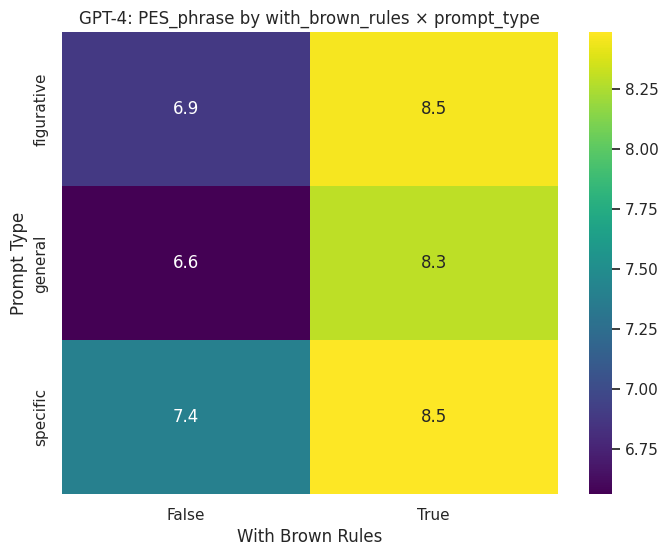

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
pivot_table = gpt4_sub.pivot(index="prompt_type",
                              columns="with_brown_rules",
                              values="PES_phrase")

sns.heatmap(pivot_table, annot=True, cmap="viridis")
plt.title("GPT-4: PES_phrase by with_brown_rules × prompt_type")
plt.ylabel("Prompt Type")
plt.xlabel("With Brown Rules")
plt.show()

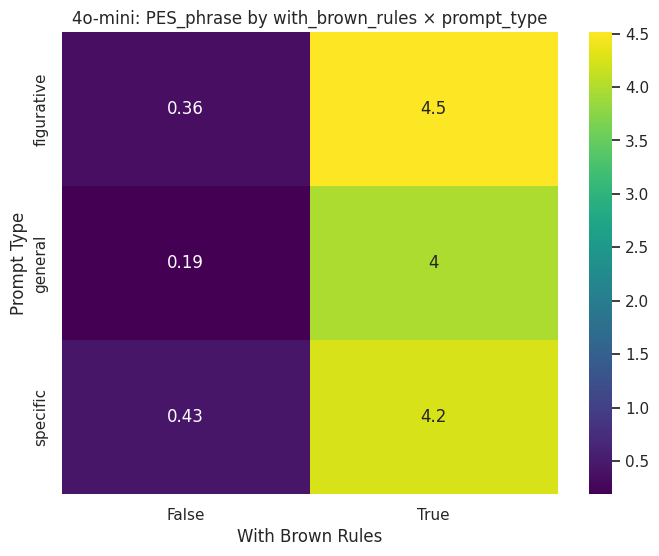

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
pivot_table_mini = mini_sub.pivot(index="prompt_type",
                                  columns="with_brown_rules",
                                  values="PES_phrase")

sns.heatmap(pivot_table_mini, annot=True, cmap="viridis")
plt.title("4o-mini: PES_phrase by with_brown_rules × prompt_type")
plt.ylabel("Prompt Type")
plt.xlabel("With Brown Rules")
plt.show()

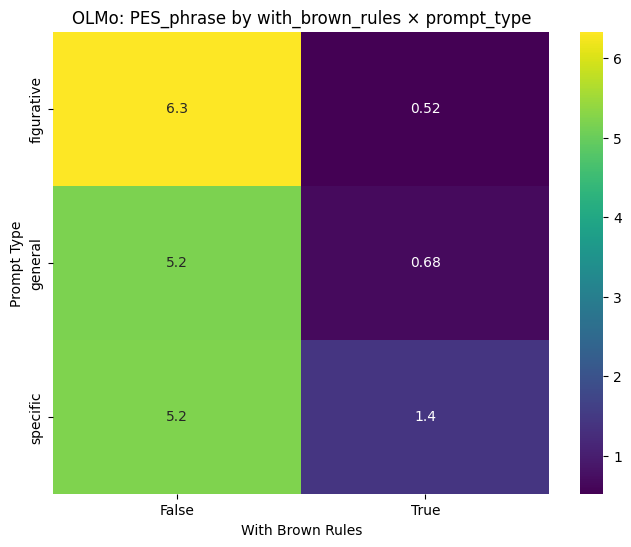

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
pivot_table = omlo_sub.pivot(index="prompt_type",
                              columns="with_brown_rules",
                              values="PES_phrase")

sns.heatmap(pivot_table, annot=True, cmap="viridis")
plt.title("OLMo: PES_phrase by with_brown_rules × prompt_type")
plt.ylabel("Prompt Type")
plt.xlabel("With Brown Rules")
plt.show()

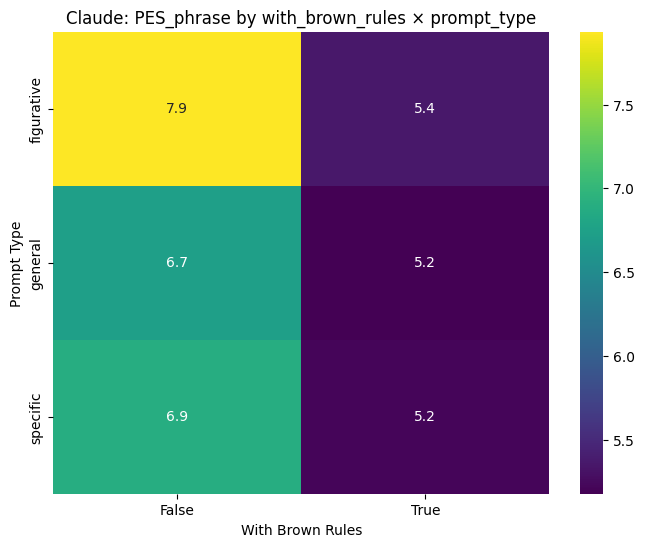

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
pivot_table = claude_sub.pivot(index="prompt_type",
                              columns="with_brown_rules",
                              values="PES_phrase")

sns.heatmap(pivot_table, annot=True, cmap="viridis")
plt.title("Claude: PES_phrase by with_brown_rules × prompt_type")
plt.ylabel("Prompt Type")
plt.xlabel("With Brown Rules")
plt.show()